# Decision Tree models with holiday features on smoothed dataset
Compare to Model-v0.2-public_holidays notebook

In [45]:
from BorderModel import BorderData, clean_df_subset
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from dbhelper import pd_query

In [4]:
query = '''
        select 
            c.date,
            waittime,
            year,
            month,
            dayofmonth,
            week,
            dayofweek,
            minofday,
            newyears,
            us_mlk,
            us_washington,
            us_memorial,
            us_independence,
            us_columbus,
            us_veterans,
            us_thanksgiving,
            xmas,
            ca_goodfriday,
            ca_victoria,
            ca_canada,
            ca_civic,
            ca_thanksgiving,
            ca_boxing,
            ca_family
        from mungedata c
        join datefeatures d on c.date = d.date
        left join publicholiday h on c.date::timestamp::date = h.date
        where
            crossing_id = 1
            and (minute = 0 or minute = 30)
        order by c.date;
        '''

df30 = pd_query(query)

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

OOB:  0.595602652958
Best score:  0.599031471479
** MSE for last cv fold **
Baseline :  96.154008876
Model    :  96.7392375104
** R^2 for last cv fold **
Baseline :  0.15028243136
Model    :  0.145110737968
** Explained variance for last cv fold **
Baseline :  0.305474073834
Model    :  0.301752188845


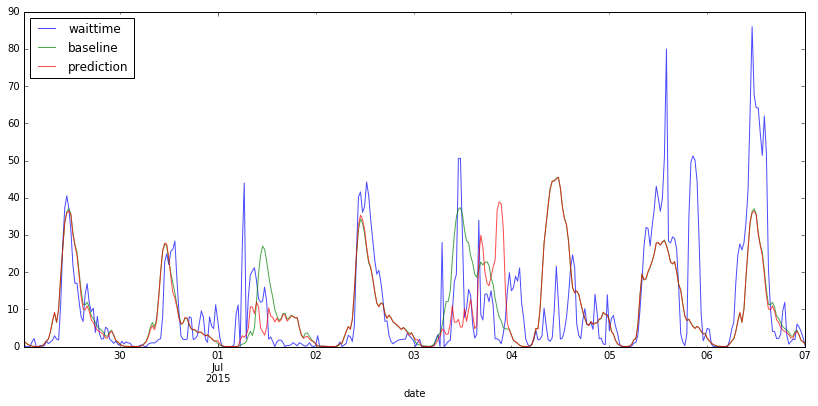

In [48]:
df = df30.drop(['dayofmonth', 'week', 'month'], axis=1)
data = BorderData(df)

model = RandomForestRegressor(n_jobs=-1, oob_score=True)
params = {'n_estimators': [100]}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid)
data.print_metrics(grid)
data.plot('6/29/15', '7/7/15');

In [31]:
print data.X.columns.values[np.argsort(grid.best_estimator_.feature_importances_)[::-1]]
print sorted(grid.best_estimator_.feature_importances_)[::-1]

['minofday' 'dayofweek' 'year']
[0.82768587354966061, 0.137127777418944, 0.035186349031395385]


## Similar to results from non-smoothed 

OOB:  0.839687871886
Best score:  0.468083161559
** MSE for last cv fold **
Baseline :  96.154008876
Model    :  120.781304034
** R^2 for last cv fold **
Baseline :  0.15028243136
Model    :  -0.0673501521238
** Explained variance for last cv fold **
Baseline :  0.305474073834
Model    :  0.0990838778941


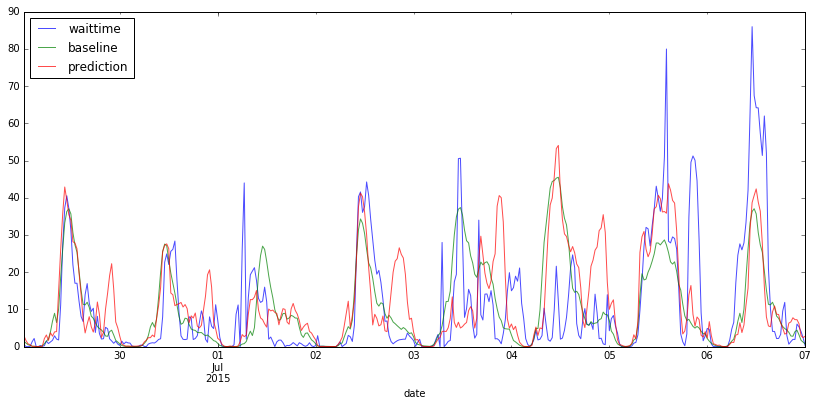

In [49]:
df = df30.drop(['dayofmonth', 'month'], axis=1)
data = BorderData(df)

model = RandomForestRegressor(n_jobs=-1, oob_score=True)
params = {'n_estimators': [100]}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid)
data.print_metrics(grid)
data.plot('6/29/15', '7/7/15');

## Similar behavior as without smoothing

## When keeping all features, RF is overfitting

OOB:  0.867338268619
Best score:  0.52847762877
** MSE for last cv fold **
Baseline :  96.154008876
Model    :  111.139203886
** R^2 for last cv fold **
Baseline :  0.15028243136
Model    :  0.0178575473801
** Explained variance for last cv fold **
Baseline :  0.305474073834
Model    :  0.187278355861


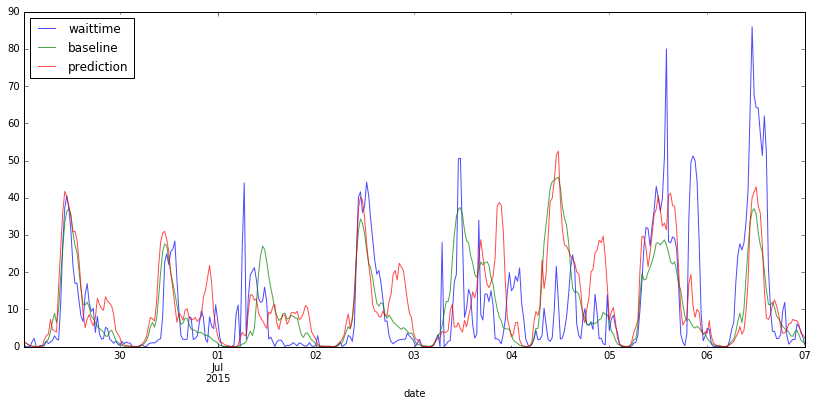

In [50]:
data = BorderData(df30)

model = RandomForestRegressor(n_jobs=-1, n_estimators=100, oob_score=True)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid)
data.print_metrics(grid)
data.plot('6/29/15', '7/7/15');

##  GBR with zero clipping feature in BorderData.predict
##  Close to baseline

Best score:  0.605763380301
** MSE for last cv fold **
Baseline :  96.154008876
Model    :  97.9191688404
** R^2 for last cv fold **
Baseline :  0.15028243136
Model    :  0.134683628453
** Explained variance for last cv fold **
Baseline :  0.305474073834
Model    :  0.312148681579


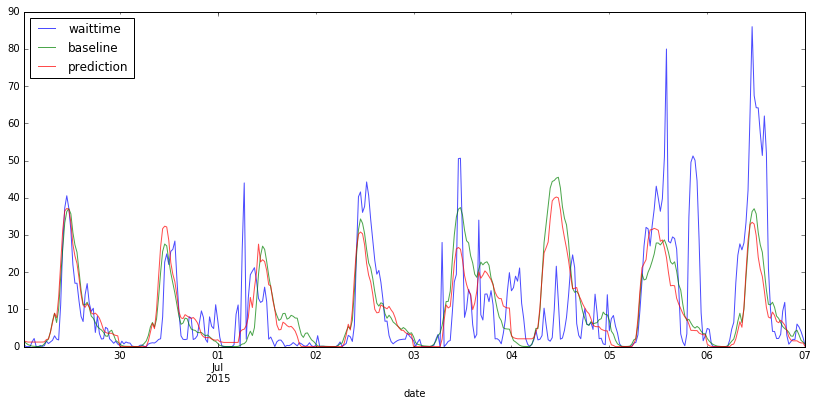

In [52]:
model = GradientBoostingRegressor(subsample=.2, n_estimators=300)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid)
data.print_metrics(grid)
data.plot('6/29/15', '7/7/15');

In [53]:
print data.X.columns.values[np.argsort(grid.best_estimator_.feature_importances_)[::-1]]
print sorted(grid.best_estimator_.feature_importances_)[::-1]

['minofday' 'week' 'dayofweek' 'year' 'dayofmonth' 'us_veterans' 'month'
 'ca_goodfriday' 'ca_boxing' 'ca_canada' 'us_washington' 'us_mlk'
 'newyears' 'ca_civic' 'us_independence' 'xmas' 'us_memorial'
 'us_thanksgiving' 'ca_victoria' 'us_columbus' 'ca_thanksgiving'
 'ca_family']
[0.47039549087764188, 0.14235956659478988, 0.10061810118092647, 0.091021195727160942, 0.072246224426950445, 0.026610875268982093, 0.025517423392270925, 0.015546124472328634, 0.01027735108640603, 0.010028408806115805, 0.0056622633062018615, 0.0051343833670476954, 0.0050377233154344997, 0.0044228146184059616, 0.0043286049012509834, 0.0039476584915857319, 0.003336838970207842, 0.0019304820014600284, 0.0015784691948320813, 0.0, 0.0, 0.0]


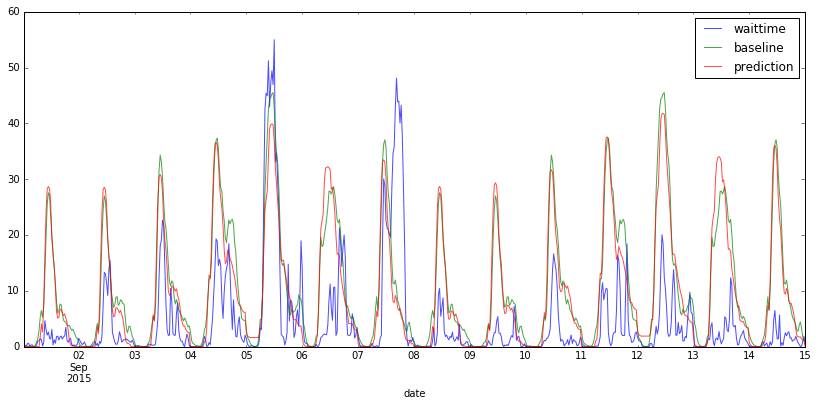

In [54]:

data.plot('9/1/15', '9/15/15');

## Conclusions
* GBR is better than RF when more features are added
* Next steps - add better features